In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
import time
import ott

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import pandas as pd
from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, MLP_FM3, MLP_no_noise, OriginalFlowMatching, MLP_FM_VAE, Bridge_MLP

2023-07-19 15:41:50.367495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

<Axes: ylabel='Density'>

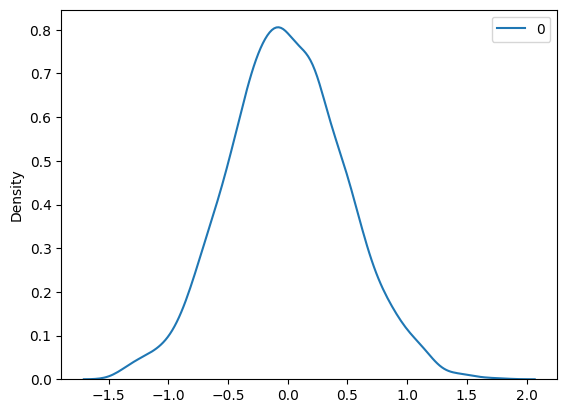

In [6]:
sns.kdeplot(source)

<Axes: ylabel='Density'>

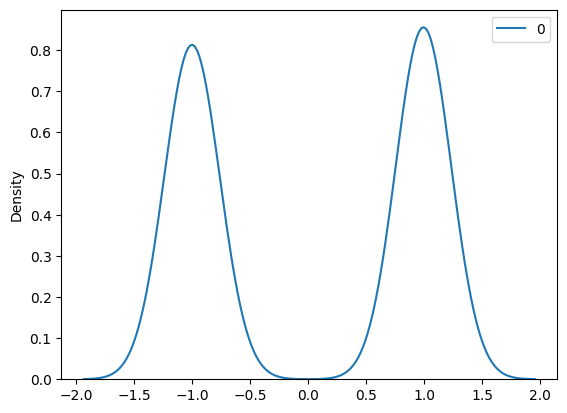

In [8]:
sns.kdeplot(target)

In [25]:
#neural_net = MLP_FM3(1, 32, 32, 32, n_frequencies=10)
#neural_net = MLP_FM(1, [64, 64, 64, 64], n_frequencies=1)
neural_net = MLP_no_noise(1, [64,64,64,64])
bridge_net = Bridge_MLP(1, 32, 32)

In [26]:
#cosine_decay_scheduler = optax.cosine_decay_schedule(1e-3, decay_steps=1_000, alpha=0.95)
#optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=1, output_dim=1, iterations=1_000, noise_std=1e-1, n_samples=100)

In [43]:
otfm.iterations=3_000
otfm(source, target, 256, 256)

100%|██████████| 3000/3000 [04:32<00:00, 11.02it/s]


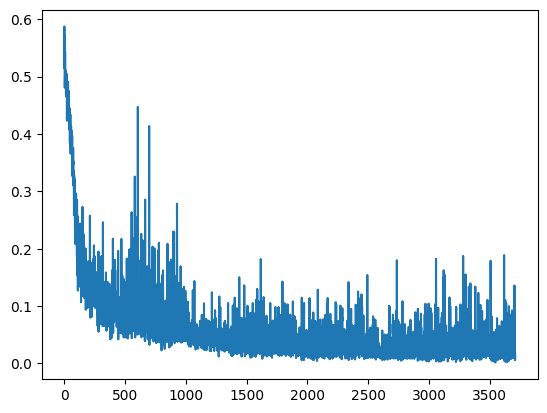

In [44]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [46]:
res, _ = otfm.transport(source, seed=0)

2023-07-19 16:11:54.789236: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: CpuCallback error: RuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

At:
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/equinox/_errors.py(45): raises
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(185): _flat_callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(45): pure_callback_impl
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(107): _callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1917): _wrapped_callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1349): __call__
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/profiler

XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: CpuCallback error: RuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

At:
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/equinox/_errors.py(45): raises
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(185): _flat_callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(45): pure_callback_impl
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/callback.py(107): _callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1917): _wrapped_callback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1349): __call__
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/pjit.py(1143): _pjit_call_impl_python
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/pjit.py(1187): call_impl_cache_miss
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/pjit.py(1203): _pjit_call_impl
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/core.py(815): process_primitive
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/core.py(383): bind_with_trace
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/core.py(2677): bind
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/pjit.py(163): _python_pjit_helper
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/pjit.py(250): cache_miss
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/equinox/_jit.py(99): _call
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/equinox/_jit.py(103): __call__
  /home/dominikk/git_repos/entot/entot/models/gen_model.py(486): transport
  /tmp/ipykernel_1643551/2941042992.py(1): <module>
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3442): run_code
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3382): run_ast_nodes
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3203): run_cell_async
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3000): _run_cell
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2945): run_cell
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/zmqshell.py(531): run_cell
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/ipkernel.py(411): do_execute
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/kernelbase.py(729): execute_request
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/kernelbase.py(499): process_one
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/asyncio/events.py(80): _run
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tornado/platform/asyncio.py(215): start
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel/kernelapp.py(711): start
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/traitlets/config/application.py(992): launch_instance
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/runpy.py(86): _run_code
  /home/dominikk/mambaforge/envs/ott_new/lib/python3.10/runpy.py(196): _run_module_as_main
; current tracing scope: custom-call.1008; current profiling annotation: XlaModule:#hlo_module=jit_diffeqsolve,program_id=927#.

In [ ]:
source_sorted = jnp.sort(source, axis=0)

In [ ]:
r =otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, source_sorted)

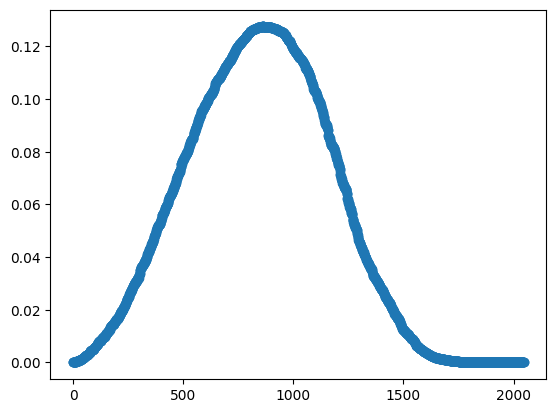

In [ ]:
plt.scatter(np.arange(len(r[1])), r[1])

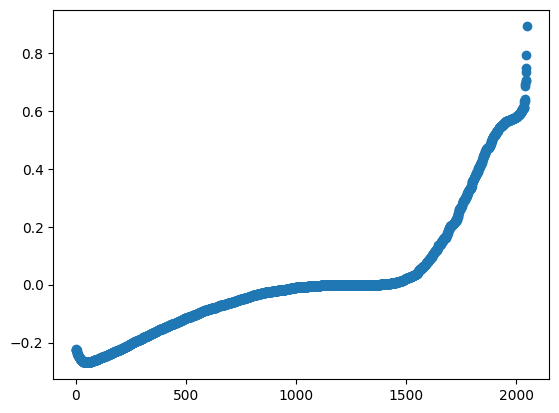

In [ ]:
plt.scatter(np.arange(len(r[0])), r[0])

<Axes: ylabel='Density'>

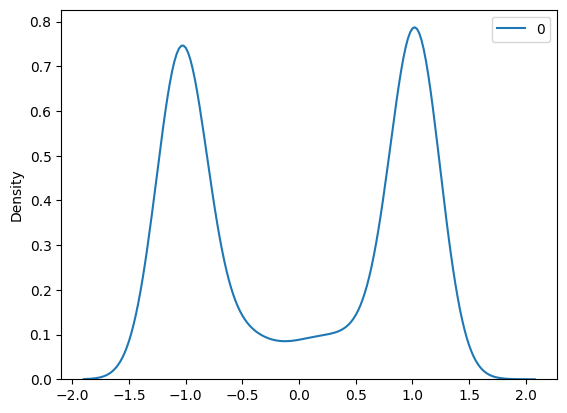

In [ ]:
sns.kdeplot(res[0,...])

In [11]:
rng = jax.random.PRNGKey(0)
latent_shape = (len(source),)
latent_batch = otfm.noise_fn(rng, shape=latent_shape) * otfm.noise_std

mu_0, sigma_0 = otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, condition=source)

mu_noisy = mu_0 + latent_batch * sigma_0 

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lambda t, y, args: otfm.state_neural_net.apply_fn({"params": otfm.state_neural_net.params}, t=t, x=y)),
    diffrax.Tsit5(),
    t0=0,
    t1=1,
    dt0=None,
    y0=mu_noisy,#latent_batch,  
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)

<Axes: ylabel='Density'>

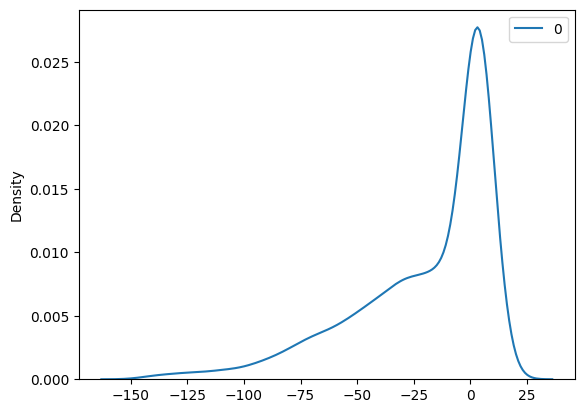

In [12]:
sns.kdeplot(solution.ys[0,...])

In [27]:
source_repeat = jnp.ones((1,)) * 0.1
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
#res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

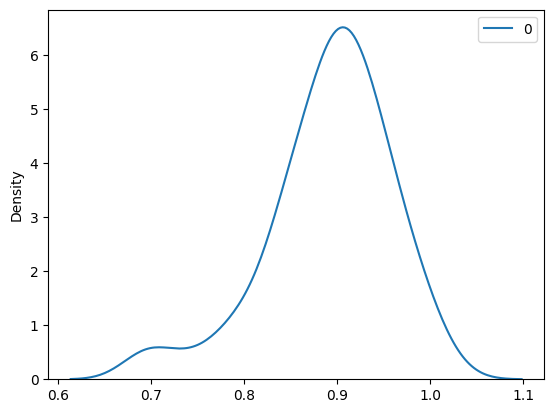

In [31]:
sns.kdeplot(res_const[0,...])

In [24]:
from functools import partial

ts = np.linspace(0,1,30)

latent_shape = (len(source),)
latent_batch = otfm.noise_fn(jax.random.PRNGKey(0), shape=latent_shape) * otfm.noise_std

apply_fn_partial = partial(
            otfm.state_mlp.apply_fn, condition=source
        )
solution = diffrax.diffeqsolve(
            diffrax.ODETerm(lambda t, y, args: apply_fn_partial({"params": otfm.state_mlp.params}, t=t, latent=y)),
            diffrax.Tsit5(),
            t0=0,
            t1=1,
            dt0=None,
            y0=latent_batch,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )

In [25]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(solution.ys)), (30,))
tracks = solution.ys[:,inds,0]

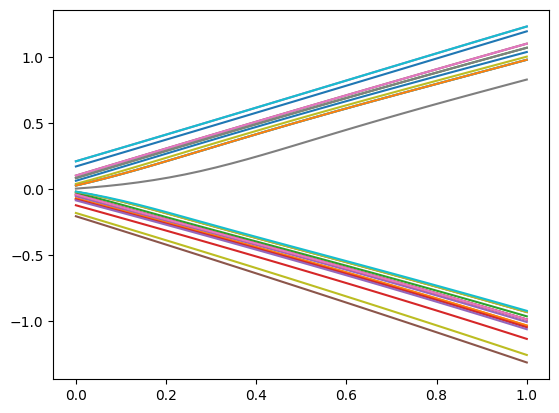

In [26]:
plt.plot(ts, tracks)
plt.show()

In [290]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

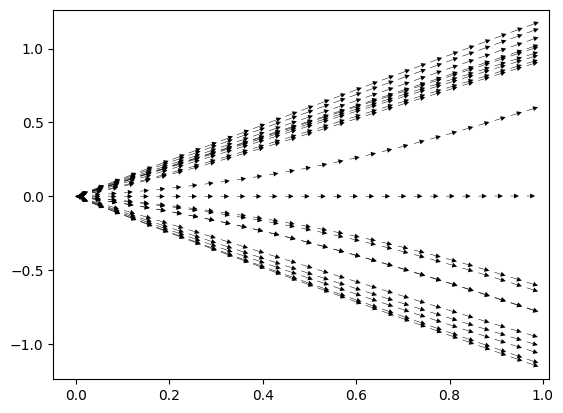

In [291]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [327]:
neural_net = MLP_no_noise(1, [64, 64, 64, 64], n_frequencies=1)
ofm = OriginalFlowMatching(neural_net, 1, 1000)

In [328]:
ofm(source, target, 64, 64)

100%|██████████| 1000/1000 [00:05<00:00, 186.10it/s]


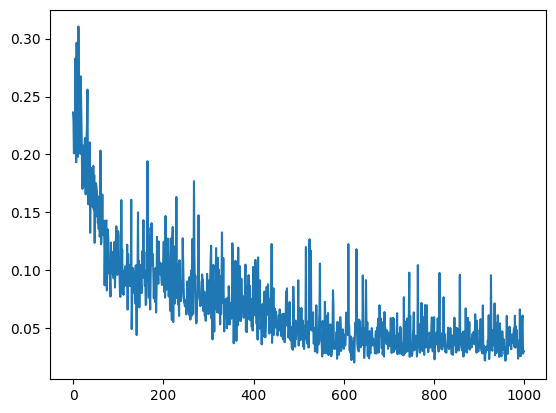

In [329]:
plt.plot(np.arange(len(ofm.metrics["loss"])), ofm.metrics["loss"])

<Axes: ylabel='Density'>

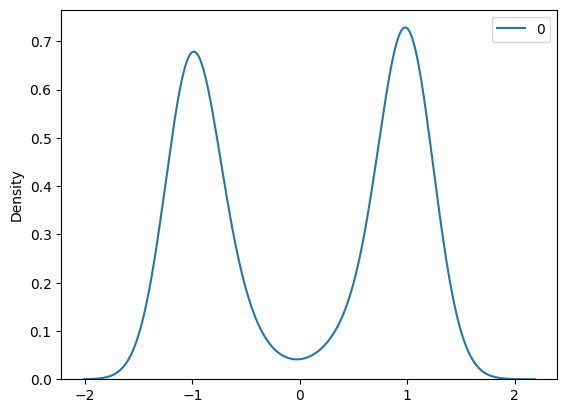

In [330]:
res,_ = ofm.transport(source)
sns.kdeplot(res[0,...])

In [331]:
solution = diffrax.diffeqsolve(
                    diffrax.ODETerm(lambda t,y,args: ofm.state_mlp.apply_fn({"params":ofm.state_mlp.params}, t=t, x=y)),
                    diffrax.Tsit5(),
                    t0=0,
                    t1=1,
                    dt0=None,
                    y0=source, # here we swap source and noise
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=ts),
                    )

In [340]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(solution.ys)), (30,))
tracks = solution.ys[:,inds,0]

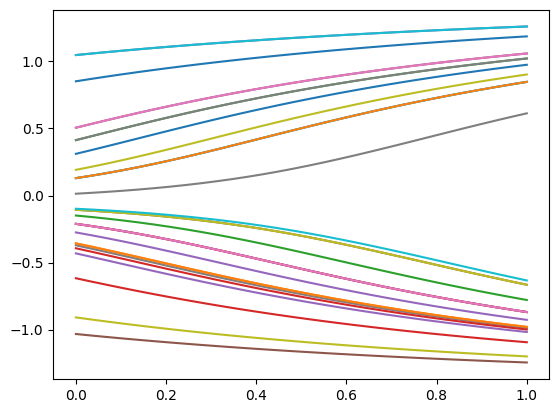

In [341]:
plt.plot(ts, tracks)
plt.show()

In [342]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

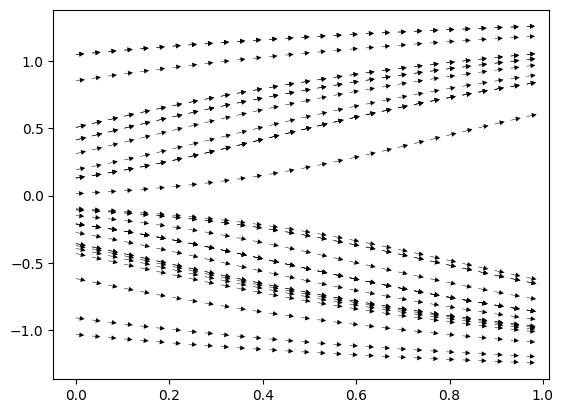

In [343]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [75]:
source_repeat = jnp.ones((1,)) * -2
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

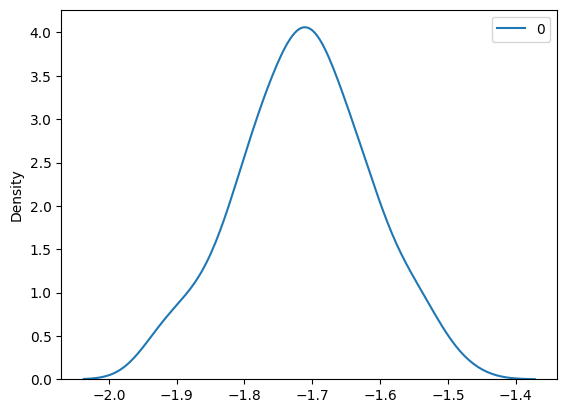

In [76]:
sns.kdeplot(res_const[0,...])

In [36]:
source_repeat = jnp.ones((1,)) * 0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

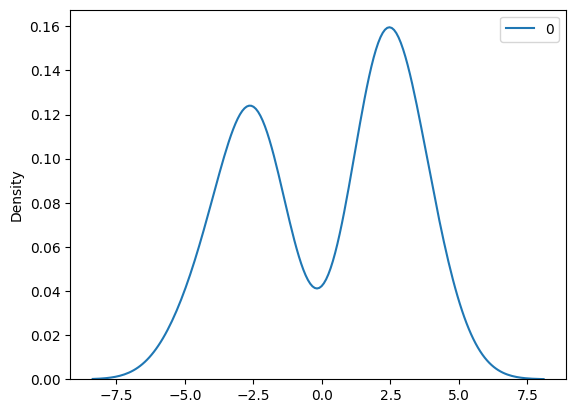

In [37]:
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

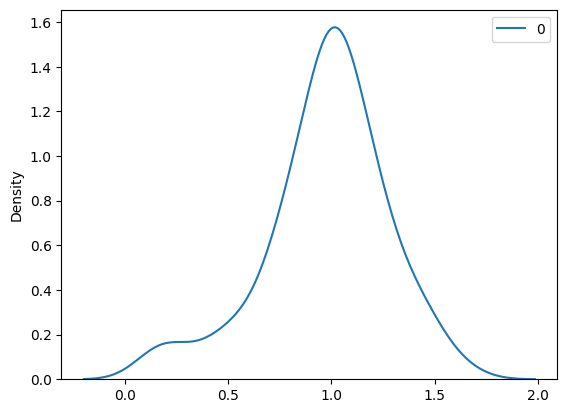

In [40]:
source_repeat = jnp.ones((1,)) * 0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

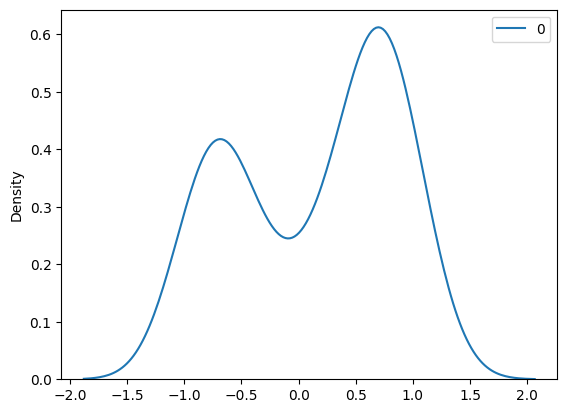

In [41]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

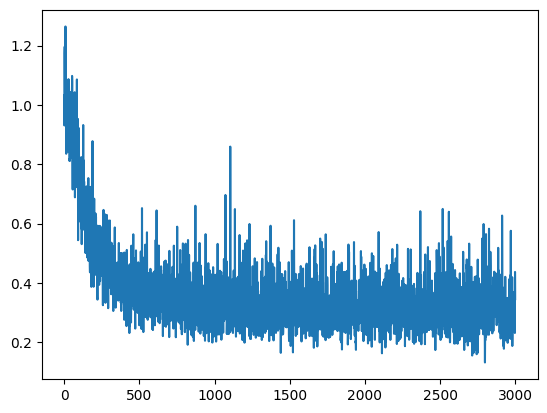

In [40]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])